In [29]:
%pylab inline
%matplotlib inline
#rollingversion
import h5py
from keras.callbacks import TensorBoard,EarlyStopping,CSVLogger,ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt  
import sys,os
import pandas as pd
import datetime
from dateutil.parser import parse
from tqdm import tqdm
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Populating the interactive namespace from numpy and matplotlib


In [10]:
def waveletSmooth( x, wavelet="db4", level=3, title=None ):
    ''' smooth denoise'''
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [11]:
def read(filePath,wetherPath = './data/zhenshitianqi.csv'):
    '''
    read data 2 dict SUM version
    '''
    
    filePath='./data/Tianchi_power.csv'
    wetherPath = './data/zhenshitianqi.csv'
    
    #get wether data
    print 'begin to read wether data'
    wetherData = pd.read_csv(wetherPath)[['date','max','min']]
    wetherData['date'] = wetherData['date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))

    #get power data
    print 'begin to read origin data'
    data = pd.read_csv(filePath)
    
    # TODO SUMALL
    print 'begin to sum'
    dataSum = pd.DataFrame()
    dataSum['sum_consumption'] = data.groupby('record_date')['power_consumption'].sum() 
    dataSum['record_date'] = dataSum.index
    
    dataSum['record_date'] = dataSum['record_date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))
    
    dataSum['week'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').weekday())
    dataSum['month'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
    dataSum['day'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)
    dataSum['year'] = dataSum['record_date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)

    #merge
    merged_data = pd.merge(dataSum,wetherData,how='left',left_on='record_date',right_on='date')

    readData = merged_data.set_index('record_date').drop('date',1)
    
    #save
    readData.to_csv("./data/dataReadSum.csv",index=False)

    print readData.head()
    return readData
    
readData = read('./data/Tianchi_power.csv')

begin to read wether data
begin to read origin data
begin to sum
             sum_consumption  week  month  day  year  max  min
record_date                                                   
2015-01-01           2900575     3      1    1  2015    8   -4
2015-01-10           3913704     5      1   10  2015   14    1
2015-01-11           3635468     6      1   11  2015   10    1
2015-01-12           4011329     0      1   12  2015    8    3
2015-01-13           3969860     1      1   13  2015    8    4


             user_id  power_consumption  week  month  day  year  max  min
record_date                                                              
2015-01-01         1               1135     3      1    1  2015    8   -4
2015-01-02         1                570     4      1    2  2015   13    0
2015-01-03         1               3418     5      1    3  2015   16    3
2015-01-04         1               3968     6      1    4  2015   15    4
2015-01-05         1               3986     0      1    5  2015   10    2


In [9]:
# 归一化保存
from sklearn.preprocessing import StandardScaler, RobustScaler

scalerDic={} # store scaler class
def scaleProcess(key,data):
    robust_scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0), copy=True)
    data['power_consumption_scale'] = robust_scaler.fit_transform(data['sum_consumption'].reshape(-1,1)) 
    scalerDic[key] = robust_scaler
    return data

scaleList=[] # userid scaled matrix
def scaleData(data):
    '''
    read data 2 dict
    '''
    scaleData = scaleProcess(0,data)
    scaleList.append(scaleData)
 
scaleData(readData)

# scaleList  save 

with open('./data/scaleListSum', 'wb') as fp:
    pickle.dump(scaleList, fp)
    
with open('./data/scalerDicSum', 'wb') as fp:
    pickle.dump(scalerDic, fp)   

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


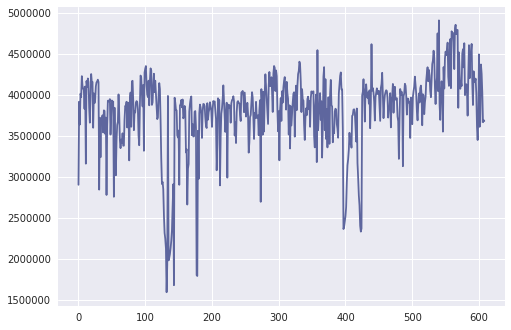

In [16]:
#check
#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
#datax = scalerDic[0].inverse_transform(scaleList[0]['power_consumption_scale'])
#plt.plot(datax)
#plt.plot(scaleList[0]['sum_consumption'].values,'r',alpha=0.1)

In [34]:
#read scale
with open ('./data/scaleListSum', 'rb') as fp:
    scaleList = pickle.load(fp)
    
with open ('./data/scalerDicSum', 'rb') as fp:
    scalerDic = pickle.load(fp)   

In [103]:
# 用去年的预测今年的数据 按照日期对应 1-7月训练 8月validation 
def getTrain(scaleList=scaleList,testMonth=8):
    originTrainXYList = []
    
    originTestXYList=[]
    
    for userData in tqdm(scaleList):
        #userData = pd.DataFrame(userData)
        #trainXY = userData[(userData.month < testMonth) & (userData.year == 2015)]
        #testXY = userData[(userData.month == testMonth) & (userData.year == 2015)]
        trainXY = userData[((userData.month < testMonth) & (userData.year == 2016) )|(userData.year == 2015) ]
        testXY = userData[(userData.month == testMonth) & (userData.year == 2016)]
        originTrainXYList.append(trainXY[['power_consumption_scale','week','max','min']])
        originTestXYList.append(testXY[['power_consumption_scale','week','max','min']])
        
    with open('./data/originTrainXYListSum', 'wb') as fp:
        pickle.dump(originTrainXYList, fp)
    
        
    with open('./data/originTestXYListSum', 'wb') as fp:
        pickle.dump(originTestXYList, fp)
 
        
    return originTrainXYList,originTestXYList

originTrainXYList,originTestXYList = getTrain()

100%|██████████| 1/1 [00:00<00:00, 169.58it/s]


In [104]:
# load
with open('./data/originTrainXYListSum', 'rb') as fp:
    originTrainXYList = pickle.load(fp)

with open('./data/originTestXYListSum', 'rb') as fp: 
    originTestXYList = pickle.load(fp)

In [105]:
originTrainXYList[0]

,power_consumption_scale,week,max,min
record_date,,,,
2015-01-01,-1.066648,3,8,-4
2015-01-10,0.012851,5,14,1
2015-01-11,-0.283612,6,10,1
2015-01-12,0.116872,0,8,3
2015-01-13,0.072686,1,8,4
2015-01-14,0.344816,2,10,4
2015-01-15,0.218210,3,11,3
2015-01-16,0.184393,4,7,-1
2015-01-17,0.162285,5,9,-1


In [106]:
# LSTM  with window regression framing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import keras.backend.tensorflow_backend as KTF

def get_session(allow_growth=True):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    gpu_options = tf.GPUOptions(allow_growth=True)


    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        
KTF.set_session(get_session(allow_growth=True))

# convert an array of values into a dataset matrix
def create_dataset(X,look_back=7):
    dataX, dataY = [], []
    for i in range(len(X)-look_back-1):
        #print X.iloc[i:(i+look_back+1)]
        #print Y.iloc[i:(i+look_back+1)]
        
        # X consumption scale
        power_consumption_scale = X.iloc[i:(i+look_back)]['power_consumption_scale']
        featureX = power_consumption_scale.tolist() # consumption
        
        # weekBinary
        tmp = [0,0,0,0,0,0,0]
        weekNum = X.iloc[i+look_back]['week']
        tmp[int(weekNum)] = 1
        featureX += tmp  #value
        
        # forecast day wether 
        wether_max = X.iloc[(i+look_back)]['max']/30.0
        wether_min = X.iloc[(i+look_back)]['min']/30.0
        featureX += [wether_max,wether_min]
        
        dataX.append(featureX)
        
        # Y consumption scale
        power_consumption_scale = X.iloc[(i+look_back)]['power_consumption_scale']
        dataY.append([power_consumption_scale]) # consumption
        
        #print dataX
        #print dataY
        
    return np.array(dataX), np.array(dataY)
dataX,dataY = create_dataset(originTrainXYList[0])

In [107]:
dataX[0]

array([-1.06664831,  0.01285112, -0.28361222,  0.11687157,  0.07268592,
        0.3448162 ,  0.21821013,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.23333333,
       -0.03333333])

In [109]:
# reshape into X=t and Y=t+1
import h5py
from keras.models import load_model
def trainData(ind=0,look_back=7):
    trainX, trainY = create_dataset(originTrainXYList[ind],look_back=look_back)
    testX, testY = create_dataset(originTestXYList[ind],look_back=look_back)
    print trainX.shape
    print testX.shape
    # reshape input to be [samples, time steps, features]
    
    # concat all data for train
    trainXAll = np.concatenate((trainX,testX),axis=0)
    trainXAlls = numpy.reshape(trainXAll, (trainXAll.shape[0], 1, trainXAll.shape[1]))
    trainYAll = np.concatenate((trainY,testY),axis=0)
        
    # for predict plot 8 yue
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(16,input_shape=(1, trainXAlls.shape[2]),return_sequences=True))
    #model.add(LSTM(8,return_sequences=False))
    #model.add(Dense(1))
    
    model.add(LSTM(8, input_shape=(1, trainX.shape[2]),return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop')
    print  model.summary()
    
    # tensor board
    tb = TensorBoard('./data/tb/{}'.format(ind), histogram_freq=1,write_graph=True, write_images=False)
    #* tensorboard --logdir path_to_current_dir/Graph --port 8080 

    # earlystoping
    ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

    # csv log
    csvlog = CSVLogger("./data/tflog/{}.log".format(ind),separator=',', append=False)

    # saves the model weights after each epoch if the validation loss decreased
    checkpointer = ModelCheckpoint(filepath="./data/weight/all_{}.h5".format(ind),verbose=1, save_best_only=True)

    ##############################
    # fit
    ##############################
    model.fit(trainX, trainY, epochs=50,batch_size=1, verbose=1,validation_data=(testX,testY),callbacks = [csvlog,checkpointer,ES])
    #model.fit(trainXAlls, trainYAll, epochs=15,batch_size=1, verbose=1,validation_split=0.1,callbacks = [csvlog,checkpointer,ES],shuffle=False)
    #
    #model.fit(trainX, trainY, epochs=50,batch_size=1, verbose=2)
    # make predictions
    model = load_model("./data/weight/all_{}.h5".format(ind))
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions
    trainPredict = scalerDic[ind].inverse_transform(trainPredict.reshape(-1,1))
    trainY = scalerDic[ind].inverse_transform(trainY.reshape(-1,1))
    testPredict = scalerDic[ind].inverse_transform(testPredict.reshape(-1,1))
    testY = scalerDic[ind].inverse_transform(testY.reshape(-1,1))
        
    # calculate root mean squared error
    print testPredict
    trainScore = math.sqrt(mean_squared_error(trainY,trainPredict))
    print('train mean_squared_error: %.2f ' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY,testPredict))
    print('test mean_squared_error: %.2f ' % (testScore))
    trainScore = math.sqrt(mean_absolute_error(trainY,trainPredict))
    print('Train mean_absolute_error: %.2f ' % (trainScore))
    testScore = math.sqrt(mean_absolute_error(testY,testPredict))
    print('Test mean_absolute_error: %.2f ' % (testScore))
    
    #trainScore = math.sqrt(r2_score(trainY,trainPredict))
    #print('Train r2_score: %.2f ' % (trainScore))
    #testScore = math.sqrt(r2_score(testY,testPredict))
    #print('Test r2_score: %.2f ' % (testScore))
    
    plt.plot(testPredict,'r-',alpha=1)
    plt.plot(testY,alpha=1)
    plt.show()
    plt.plot(trainPredict,'r-',alpha=1)
    plt.plot(trainY,alpha=1)
    plt.show()
    

(570, 16)
(23, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________
None
Train on 570 samples, validate on 23 samples
Epoch 1/50
570/570 [==============================] - 11s - loss: 0.2183 - val_loss: 0.1137
Epoch 2/50
570/570 [==============================] - 2s - loss: 0.1487 - val_loss: 0.0964
Epoch 3/50
570/570 [==============================] - 2s - loss: 0.1299 - val_loss: 0.0951
Epoch 4/50
570/570 [==============================] - 2s - loss: 0.1202 - val_loss: 0.0987
Epoch 5/50
570/570 [==============================] - 2s - loss: 0.1175 - val_loss: 0.0977
Epoch 6/50
570/

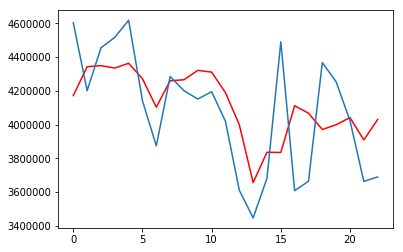

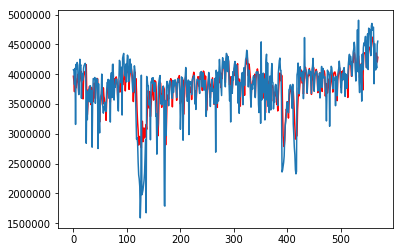

In [110]:
trainData(ind=0)

In [111]:
# predict
# 获取9月的训练数据
def get9data():
    '''
    天气数据
    '''
    #get wether
    wetherPath = './data/tianqiyubao.csv'
    #get wether data
    data = pd.read_csv(wetherPath)[['date','max','min']]
    data['date']  = data['date'].apply(lambda x:parse(str(x)).strftime('%Y-%m-%d'))
    data['week']  = data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').weekday())
    data['month'] = data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
    data['day']   = data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)
    data['year']  = data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)
    
    return data

wether9 = get9data()

feature:
[[[ 0.0087244   0.11692378  0.13593888 -0.44086769 -0.03586614 -0.09616124
    0.22180622  0.          0.          0.          1.          0.          0.
    0.          1.1         0.73333333]]]
[[ 0.19845802]]
[0.19845802]
feature:
[[[ 0.11692378  0.13593888 -0.44086769 -0.03586614 -0.09616124  0.22180622
    0.19845802  0.          0.          0.          0.          1.          0.
    0.          1.13333333  0.73333333]]]
[[ 0.17115214]]
[0.19845802, 0.17115214]
feature:
[[[ 0.13593888 -0.44086769 -0.03586614 -0.09616124  0.22180622  0.19845802
    0.17115214  0.          0.          0.          0.          0.          1.
    0.          1.1         0.76666667]]]
[[ 0.06647732]]
[0.19845802, 0.17115214, 0.066477321]
feature:
[[[-0.44086769 -0.03586614 -0.09616124  0.22180622  0.19845802  0.17115214
    0.06647732  0.          0.          0.          0.          0.          0.
    1.          1.06666667  0.73333333]]]
[[-0.17327112]]
[0.19845802, 0.17115214, 0.066477321, -0

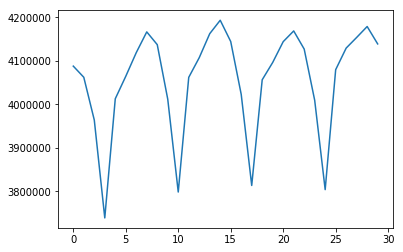

array([[ 4087899.25],
       [ 4062272.25],
       [ 3964033.  ],
       [ 3739025.  ],
       [ 4012897.  ],
       [ 4064547.75],
       [ 4118946.25],
       [ 4166583.75],
       [ 4137264.  ],
       [ 4011901.  ],
       [ 3798517.  ],
       [ 4062090.75],
       [ 4107363.  ],
       [ 4162482.25],
       [ 4193372.75],
       [ 4144386.75],
       [ 4022897.25],
       [ 3813627.25],
       [ 4056552.5 ],
       [ 4096366.  ],
       [ 4144136.25],
       [ 4168784.25],
       [ 4127112.25],
       [ 4009436.75],
       [ 3804058.25],
       [ 4079729.5 ],
       [ 4129378.25],
       [ 4153859.  ],
       [ 4178939.25],
       [ 4138983.25]], dtype=float32)

In [112]:
# convert an array of values into a dataset matrix
def getPre(userData=scaleList[0],preMonth=9,look_back=7):
    '''
    获取最终预测数据X
    '''
    preXlist = []

    X = userData[((userData.month == 8) & (userData.day >= 25) & (userData.year == 2015)) | ((userData.month == 9) & (userData.year == 2015))]
    Y = wether9
    #print X
    #print Y
    model = load_model("./data/weight/all_{}.h5".format(0))

     
    history_power=np.zeros(look_back)
    pre_value = 0
    prelist = []
    for i in range(len(Y)):
        
        if i == 0:
            power_consumption_scale = X.iloc[i:(i+look_back)]['power_consumption_scale']
        else:
            power_consumption_scale = np.concatenate([history_power[1:],pre_value[0]])
            
        featureX = power_consumption_scale.tolist() # consumption    
        history_power=featureX[:]    
        # weekBinary
        tmp = [0,0,0,0,0,0,0]
        weekNum = wether9.iloc[i]['week']
        tmp[int(weekNum)] = 1
        featureX += tmp  #value

        # forecast day wether 
        wether_max = Y.iloc[i]['max']/30.0
        wether_min = Y.iloc[i]['min']/30.0
        featureX += [wether_max,wether_min]
        
        # predict 

        featureX = np.array([featureX])
        X = np.reshape(featureX, (featureX.shape[0], 1, featureX.shape[1]))
        print "feature:"
        print X
        pre_value = model.predict(X, verbose=0)
        
        print pre_value
        prelist.append(pre_value[0][0])
        print prelist
        
    
    testPredict = scalerDic[0].inverse_transform(np.array(prelist).reshape(-1,1))
    plt.plot(testPredict)
    plt.show()
    return testPredict
getPre()

In [72]:
import h5py
from keras.models import load_model
def trainData(ind=0,look_back=7):
    X = getPre()
    # reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # create and fit the LSTM network
    #model = Sequential()
    #model.add(LSTM(5, input_shape=(1, trainX.shape[2]),))
    #model.add(Dense(1))
    #model.compile(loss='mean_squared_error', optimizer='rmsprop')
    #print  model.summary()
    
    model = load_model("./data/weight/{}.h5".format(ind))

    y_pred = model.predict(X, verbose=0)
    
    testPredict = scalerDic[ind+1].inverse_transform(y_pred.reshape(-1,1)) 
    return testPredict

In [66]:
# loop pre 
preEndList=[]
for i in tqdm(arange(len(scaleList))[:5]):
    preEndList.append(trainData(i).reshape(1,-1)[0])
split_pre = np.vstack(preEndList)

with open('./data/split_pre', 'wb') as fp:
    pickle.dump(split_pre, fp) 

100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


In [67]:
split_pre

array([[  356.98040771,   356.39678955,   333.29238892,   229.93112183,
          311.44726562,   323.87832642,   273.81182861,   334.78613281,
          354.96459961,   380.44985962,   270.9407959 ,   342.1751709 ,
          377.20120239,   357.8565979 ,   379.17294312,   360.58209229,
          306.53692627,   125.96551514,   275.04608154,   300.98828125,
          302.15203857,   348.40167236,   304.53210449,   289.59399414,
           72.32168579,   279.3258667 ,   333.66003418,   301.0333252 ,
          356.11300659,   296.83947754],
       [  244.2702179 ,   235.61352539,   248.76837158,   167.34654236,
          211.80621338,   233.32170105,   203.20155334,   230.80099487,
          238.96109009,   235.85153198,   188.3008728 ,   237.05326843,
          286.18862915,   194.38853455,   212.84420776,   224.33862305,
          254.26332092,   165.50416565,   198.87287903,   227.51596069,
          208.72607422,   192.67234802,   201.20878601,   221.8387146 ,
          127.01296234,

In [76]:
real = scaleList[4]
real[(real.year == 2015) & (real.month == 9 )]

,user_id,power_consumption,week,month,day,year,max,min,power_consumption_scale
record_date,,,,,,,,,
2015-09-01,5,1089,1,9,1,2015,29,22,0.043462
2015-09-02,5,1034,2,9,2,2015,30,22,0.008309
2015-09-03,5,707,3,9,3,2015,29,22,-0.200690
2015-09-04,5,788,4,9,4,2015,30,23,-0.148920
2015-09-05,5,1250,5,9,5,2015,28,22,0.146363
2015-09-06,5,1405,6,9,6,2015,28,21,0.245430
2015-09-07,5,1487,0,9,7,2015,28,21,0.297840
2015-09-08,5,1426,1,9,8,2015,28,20,0.258852
2015-09-09,5,1463,2,9,9,2015,28,19,0.282500


In [64]:
endData = split_pre.sum(axis=0)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


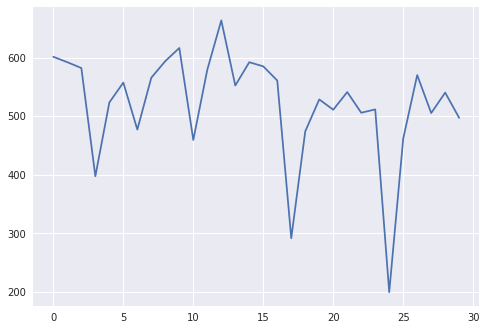

In [65]:
plot(endData)